<center>

# Genómica Predictiva: Clasificación de Bacterias Resistentes a Antibióticos mediante XGBoost

**Autor:** Richard Muñoz Henao  
**Universidad:** Universidad Nacional de Colombia  
**Fecha:** 3 de noviembre de 2025

</center>

---

La resistencia a antibióticos es uno de los mayores desafíos en salud pública. La capacidad de predecir si una cepa bacteriana es resistente a ciertos antibióticos usando análisis genómicos permite acelerar diagnósticos y mejorar estrategias de tratamiento.

En este proyecto se emplea **XGBoost**, un algoritmo de **aprendizaje supervisado basado en árboles de decisión**, para clasificar bacterias según sus perfiles genómicos y su resistencia a antibióticos. Los objetivos principales son:

- Identificar patrones genéticos asociados a la resistencia.  
- Construir modelos robustos y precisos.  
- Evaluar la aplicabilidad de técnicas de **machine learning en genómica predictiva** mediante métricas como precisión, recall, F1-score y curvas ROC.


# 1. Exploración inicial de los datos

In [2]:
from Bio import SeqIO
import re
from collections import defaultdict
from pathlib import Path
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
import subprocess
import sys
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import pyrodigal
from concurrent.futures import ProcessPoolExecutor, as_completed
import cupy as cp
from sklearn.model_selection import train_test_split
import xgboost as xgb


In [5]:
iterador = SeqIO.parse("Genoma_ejemplo.fasta","fasta")
primera_secuencia = next(iterador)
print("Longitud del primer genoma: ", len(primera_secuencia.seq))
idGenoma = ".".join(primera_secuencia.id.replace("|", ".").split(".")[1:3])
print(idGenoma) # esta sera la clave para identificar cada genoma
print(f"ID: {primera_secuencia.description}\nSecuencia: {primera_secuencia.seq[:10000]}") # mostrar primeras 10000 bases nitrogenadas


Longitud del primer genoma:  467848
562.145820
ID: accn|562.145820.con.0001   SRR10969696_contig_1   [Escherichia coli S20323 | 562.145820]
Secuencia: tgccgaagtcaccgcagacagcggggaatatcaggtgctggcgcgctgggacacgccgaaggtggtgaagggtgtgagctttatgcttcgcctgaccgtaacagcggatgacggcagtgagcggctggtcagcacggcccggacgatggaaaccacttaccgcttcacacaactggcgctggggaactacaggctgacagtccgggcagtaaatgcgtgggggcagcagggcgatccggcgtcggtatcgttccggattgccgcaccggcagcgccgtcgcggattgagctgacgccgggctattttcagataaccgccacgccgcatcttgcggtttatgatccgacggtacagtttgagttctggttctcggaaaagcggattgcggatatcaggcaggttgaaaccacagcacgctatcttggcacggcgctgtactggatagccgccagtatcaatatcaaaccgggccatgattattacttttatatccgcagtgtgaacaccgttggcaaatcggcattcgtggaggctgtcggtcagccgagtgatgatgcatcaggctatctggattttttcaaaggagaaatcgggaaaacacatctggcccaggagctgtggacgcagattgataacggtcagcttgcgcctgacctggctgaaatcaggacgtccattacggatgtcagcaatgaaatcacacagaccgtcaataagaaactggaagaccagagtgcagcgatccagcagatacagaaagttcaggttgatacaaataataacctgaacagcatgtgggctgtgaagctgcagcagatgcaggacggacgcctttatattgcgggtat

# 2. Extracción de los embeddings del genoma bacteriano (K-MERS)

In [3]:
from itertools import product

K = 6
BASES = ['a','t','g','c']
kmerslist = list(product(BASES, repeat = K))
kmerslist = [''.join(x) for x in kmerslist]
kmersdict = {x: 0 for x in kmerslist} # Convertir en diccionario, clave: numero de apariciones del kmer

print("longitud de kmerslist: ", len(kmerslist))
print(kmerslist)

longitud de kmerslist:  4096
['aaaaaa', 'aaaaat', 'aaaaag', 'aaaaac', 'aaaata', 'aaaatt', 'aaaatg', 'aaaatc', 'aaaaga', 'aaaagt', 'aaaagg', 'aaaagc', 'aaaaca', 'aaaact', 'aaaacg', 'aaaacc', 'aaataa', 'aaatat', 'aaatag', 'aaatac', 'aaatta', 'aaattt', 'aaattg', 'aaattc', 'aaatga', 'aaatgt', 'aaatgg', 'aaatgc', 'aaatca', 'aaatct', 'aaatcg', 'aaatcc', 'aaagaa', 'aaagat', 'aaagag', 'aaagac', 'aaagta', 'aaagtt', 'aaagtg', 'aaagtc', 'aaagga', 'aaaggt', 'aaaggg', 'aaaggc', 'aaagca', 'aaagct', 'aaagcg', 'aaagcc', 'aaacaa', 'aaacat', 'aaacag', 'aaacac', 'aaacta', 'aaactt', 'aaactg', 'aaactc', 'aaacga', 'aaacgt', 'aaacgg', 'aaacgc', 'aaacca', 'aaacct', 'aaaccg', 'aaaccc', 'aataaa', 'aataat', 'aataag', 'aataac', 'aatata', 'aatatt', 'aatatg', 'aatatc', 'aataga', 'aatagt', 'aatagg', 'aatagc', 'aataca', 'aatact', 'aatacg', 'aatacc', 'aattaa', 'aattat', 'aattag', 'aattac', 'aattta', 'aatttt', 'aatttg', 'aatttc', 'aattga', 'aattgt', 'aattgg', 'aattgc', 'aattca', 'aattct', 'aattcg', 'aattcc', 'aatgaa', 

## Funcion para extraer los k-mers de una secuencia de bases nitrogenadas

In [4]:
def getkmers(seq, idGenoma = "", k=K):
    seq = str(seq)
    counts = defaultdict(int)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmersdict:
            counts[kmer] += 1
    return counts

## Funcion para extraer orfs
Los orfs son los fragmentos del genoma que codifican para proteinas, por lo tanto las mutaciones de resistencia se suelen presentar en estas subsecuencias entonces vale la pena aislarlos.

In [5]:
seqs = [str(rec.seq) for rec in SeqIO.parse("Genoma_ejemplo.fasta", "fasta")]
genoma = "NNNNNNNNNN".join(seqs)
predictor = pyrodigal.GeneFinder(meta=False)
predictor.train(sequence=genoma)

def procesarGenes(secuencia, idGenoma, predictor = predictor):
    genes = predictor.find_genes(secuencia)
    orfConcatenado = "".join(str(g.translate()) for g in genes)
    return idGenoma, orfConcatenado

## Procesar los genomas para obtener los datos tabulares con las características
En este paso concatenamos todos los contigs correspondientes a un mismo genoma, extraemos los k-mers y colocamos los resultados en una lista con diccionarios.

In [14]:
%%time
registroKmersSuceptible = [] 
registroKmersResistant = []
regexGenomaid = re.compile(r"\|\s(\d*\.\d*)\]")

for carpeta in [Path("suceptible/"), Path("resistant/")]:
    registroKmers = registroKmersSuceptible if carpeta == Path("suceptible/") else registroKmersResistant
    for archivoFasta in sorted(carpeta.iterdir()):
        print("\n")
        print("Concatenando contigs", archivoFasta)
        genomas = defaultdict(list)
        
        for contig in SeqIO.parse(archivoFasta, "fasta"):
            idGenoma = regexGenomaid.findall(contig.description)
            idGenoma = ".".join(idGenoma)
            genomas[idGenoma].append(str(contig.seq))
        
        #genomasSecuencias = {idGenoma: "".join(contigs) for idGenoma, contigs in genomas.items()}
        #genomas.clear()
        genomasSecuencias = {}
        a = 1 
        while genomas:
            # popitem() extrae y elimina el elemento del diccionario original para liberar RAM
            idGenoma, contigs = genomas.popitem()
            
            # 1. Unimos los contigs originales
            secuencia_original = "".join(contigs).lower()
            
            # 2. Generamos el reverso complemento
            # Usamos la clase Seq de Biopython para el cálculo rápido
            reverso_comp = str(Seq(secuencia_original).reverse_complement())
            
            # 3. Concatenamos ambos con un espaciador de seguridad
            # Esto duplica el tamaño del string, pero al haber borrado 'contigs' 
            # y estar vaciando 'genomas', tu RAM estará más protegida.
            genomasSecuencias[idGenoma] = secuencia_original + "NNNNNNNNNN" + reverso_comp
            if a ==1:
                print(genomasSecuencias[idGenoma][:15])
            a = 2
            # Limpieza manual para el recolector de basura
            del contigs
        
        contador = 0
        with ProcessPoolExecutor() as executor: # Encontrar orfs
            futures = {executor.submit(procesarGenes, seq, idG): idG for idG, seq in genomasSecuencias.items()}
            for future in as_completed(futures):
                idGenoma, orfSeq = future.result()
                genomas[idGenoma] = orfSeq
                contador += 1
                print(f"\rORFs encontrados con éxito {contador} / {len(genomasSecuencias)}", end="")
        
        contador = 0
        with ProcessPoolExecutor() as executor: # Encontrar kmers
            futures = {executor.submit(getkmers, genomasSecuencias[idGenoma], idGenoma): idGenoma for idGenoma in genomasSecuencias}
            for future in as_completed(futures):
                registroKmers.append(future.result())
                contador += 1
                print(f"\rProcesando k-mers del genoma {contador} / {len(genomas)}", end="")



Concatenando contigs suceptible/suceptible1.fasta
tgccgaagtcaccgc
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptible10.fasta
agtagtgtggggtct
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptible11.fasta
gcagtacctgtaata
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptible12.fasta
attacccgccgccag
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptible13.fasta
cttatactcccacat
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptible14.fasta
cccaccggcgcgggc
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptible15.fasta
agcttttcattctga
Procesando k-mers del genoma 27 / 27

Concatenando contigs suceptible/suceptible2.fasta
cttatactcccacat
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptible3.fasta
catagagtgtaaaga
Procesando k-mers del genoma 200 / 200

Concatenando contigs suceptible/suceptib

## Convertir en dataframe, agregar etiquetas de resistencia y exportar como csv

In [15]:
dfResistant = pd.DataFrame(registroKmersResistant)
dfSuceptible = pd.DataFrame(registroKmersSuceptible)
dfResistant["Resistant"] = True
dfSuceptible["Resistant"] = False
df = pd.concat([dfSuceptible, dfResistant], ignore_index=True)
df = df.fillna(0)
df.to_csv("kmers.csv", index = False)

# 3. Visualizar datos

In [16]:
import pandas as pd
df = pd.read_csv("kmers.csv")
print(df.shape)
df.tail(10)


(6460, 4097)


,aagcgg,agcgga,gcggag,cggaga,ggagag,gagagc,agagcg,gagcga,agcgat,gcgatt,...,cctaga,actagg,atctag,ctaggg,ctaggc,gcctag,ctagac,ctagtc,cctagg,Resistant
6450,3764,2745,1788,2024,1481,1461,2079,1891,4052,4302,...,69,85,99,81,96,96,63,97,26,True
6451,4199,3083,1989,2367,1740,1674,2437,2205,4507,4779,...,82,113,134,79,116,116,59,110,54,True
6452,3809,2781,1809,2092,1579,1490,2115,1890,4153,4355,...,64,92,110,80,90,90,70,108,36,True
6453,3869,2795,1790,1991,1541,1462,2115,2006,4133,4496,...,45,87,112,70,89,89,64,118,30,True
6454,3868,2853,1839,2114,1575,1484,2167,1928,4177,4375,...,72,97,102,81,116,116,62,111,36,True
6455,3802,2765,1794,2060,1544,1459,2082,1850,4057,4308,...,62,94,115,83,89,89,66,115,34,True
6456,3938,2901,1856,2083,1577,1555,2195,1980,4201,4454,...,56,90,101,81,79,79,61,123,28,True
6457,3906,2857,1818,2024,1534,1546,2157,1975,4176,4443,...,61,93,105,77,82,82,59,122,32,True
6458,3844,2771,1796,2052,1527,1459,2118,1916,4130,4332,...,55,89,99,73,96,96,63,98,16,True
6459,3747,2701,1732,1983,1506,1443,2063,1883,4041,4259,...,59,81,103,71,87,87,62,101,22,True


# 4. Entrenamiento con XGBoost

## Split de los datos

In [4]:
y = df["Resistant"].values
x = df.drop('Resistant', axis = 1)

# convertir a frecuencias relativas
suma_filas = x.sum(axis = 1)
x = x.div(suma_filas, axis = 0)
x = x.values

# Convertir todo a GPU
#x = cp.array(x)
#y = cp.array(y)

# Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20) # train se utilizara con validacion cruzada

# Crear DMatrix en GPU
#dtrain = xgb.DMatrix(x_train, label=y_train)
#deval = xgb.DMatrix(x_test, label=y_test)

#print(y)
#print(x)

NameError: name 'df' is not defined

# Modelo de redes neuronales recurrentes

Diccionario de indices de los k-mers para embeddings

In [16]:
from itertools import product

K = 6
BASES = ['a', 't', 'g', 'c']

# Generamos todas las combinaciones
kmers_combinaciones = list(product(BASES, repeat=K))
kmers_list = [''.join(x) for x in kmers_combinaciones]

# Creamos el diccionario de mapeo: { 'aaaaaa': 0, 'aaaaat': 1, ... }
kmer_to_idx = {kmer: i for i, kmer in enumerate(kmers_list)}

print(f"Diccionario creado con {len(kmer_to_idx)} k-mers.")
print(f"Índice de 'aaaaaa': {kmer_to_idx['aaaaaa']}")
print(f"Índice de 'cccccc': {kmer_to_idx['cccccc']}")


Diccionario creado con 4096 k-mers.
Índice de 'aaaaaa': 0
Índice de 'cccccc': 4095


In [15]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hiperparametros
input_size = 28
sequence_length = 28
num_layers = 2
hidden_size = 256
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 2

embedding_dim = 4098
vocab_size = len(kmer_to_idx)

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        _, hn = self.rnn(x, h0)
        out = out
        out = hn[-1, :, :]
        out = self.fc(out)
        return out



In [16]:
# Cargar datos
x_tensor = torch.from_numpy(x_train).float()
y_tensor = torch.from_numpy(y_train).float()

# 2. Empaquetar en un Dataset
dataset = TensorDataset(x_tensor, y_tensor)

# 3. Definir el DataLoader
batch_size = 32 # Puedes ajustar esto según tu memoria
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True  # Mezcla los datos en cada época (muy importante para entrenar)
)

NameError: name 'x_train' is not defined

In [ ]:
# Optimizador y funcion de perdida
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# Entrenar red neuronal

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(dataloader):
        data = data.to(device=device)
        targets = targets.to(device = device)

        data = data.reshape(data.shape[0], -1)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # cambio de pesos con adam
        optimizer.step()


# 5. Visualización y métricas de los resultados

In [74]:
# Predicciones y evaluación
y_pred_proba = bst_final.predict(deval)
y_pred = (y_pred_proba > 0.5).astype(int)
y_test_cpu = cp.asnumpy(y_test)
accuracy = (y_pred == y_test_cpu).mean()

resultados = pd.DataFrame()
resultados['test'] = y_test.get().astype(int)
resultados['pred'] = y_pred.astype(int)
resultados.tail(10)

,test,pred
1282,1,1
1283,0,0
1284,0,1
1285,1,1
1286,1,1
1287,1,1
1288,0,0
1289,0,0
1290,1,1
1291,0,0


## Métricas de clasificación binaria

\begin{align*}
\text{Precision (Precisión)} &= \frac{TP}{TP + FP} \\[2mm]
\text{Recall (Sensibilidad)} &= \frac{TP}{TP + FN} \\[2mm]
\text{F1-score} &= 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} \\[2mm]
\text{Support} &= \text{Número de muestras reales de cada clase} \\[2mm]
\text{Accuracy (Exactitud)} &= \frac{TP + TN}{TP + TN + FP + FN} \\[2mm]
\text{Macro Average} &= \frac{1}{2} (\text{métrica para clase True} + \text{métrica para clase False}) \\[2mm]
\text{Weighted Average} &= \frac{(\text{métrica clase True} \cdot \text{support True}) + (\text{métrica clase False} \cdot \text{support False})}{\text{support True} + \text{support False}} \\[2mm]
\text{ROC-AUC} &= \text{Área bajo la curva ROC, que mide la capacidad de separar clases} 
\end{align*}


In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import cupy as cp
import numpy as np
from sklearn.metrics import (roc_auc_score,roc_curve,classification_report,)
import matplotlib.pyplot as plt

y_true = y_test_cpu
y_pred_labels = y_pred

# Reporte detallado de las metricas
roc_auc = roc_auc_score(y_true, y_pred_proba)
report = classification_report(y_true, y_pred_labels)
print(report)
print(f"ROC-AUC: {roc_auc:.4f}")

              precision    recall  f1-score   support

       False       0.82      0.77      0.80       571
        True       0.83      0.87      0.85       721

    accuracy                           0.83      1292
   macro avg       0.83      0.82      0.82      1292
weighted avg       0.83      0.83      0.83      1292

ROC-AUC: 0.8902


# Matriz de confusión

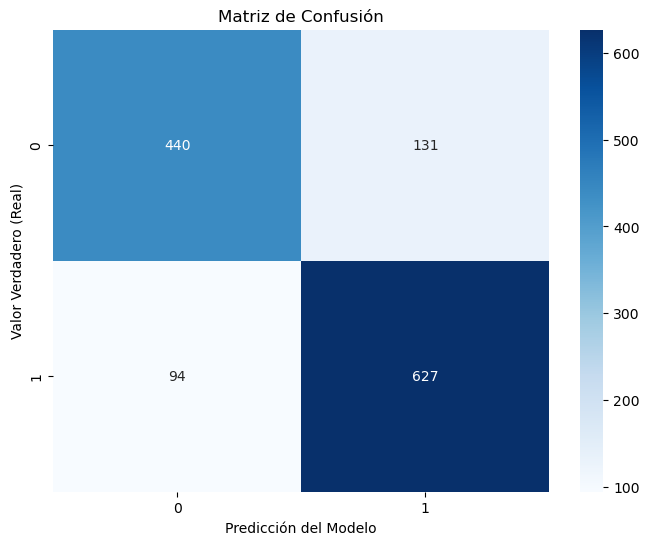

In [76]:
cm = confusion_matrix(y_test.get(), y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Matriz de Confusión')
plt.ylabel('Valor Verdadero (Real)')
plt.xlabel('Predicción del Modelo')
plt.show()

# Curva ROC

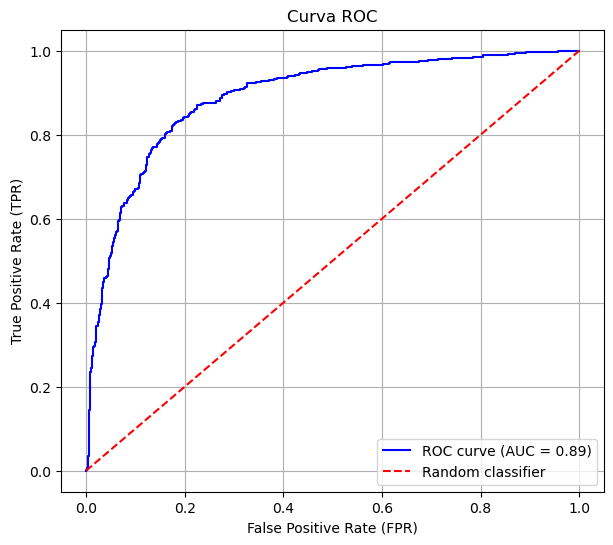

In [77]:

fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()